### Эксперименты с моделями

**Что надо сделать**

Упростить код. Добавить `sklearn.pipeline` и вывести все в удобный датафрейм через `pd.concat([df, cross_validate(...)], axis=1)`. Добавить подбор гиперпараметров. Единая функция для всех моделей.

Совместить с `mode.ipynb` в `main`.

Провести EDA для Илона Маска.

**Импорт зависимостей**

In [1]:
import re
import pandas as pd
import numpy as np
from html import unescape
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag, ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier
import catboost as cb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Загрузка данных**

In [3]:
df = pd.read_csv('elon_musk_tweets_labeled.csv').drop(['id', 'hashtags', 'user_name', 'user_created', 'is_retweet', 'Unnamed: 0', 'date'], axis=1)

In [4]:
df = pd.get_dummies(
    df, 
    columns=['user_location', 'user_description', 'user_verified', 'source'], 
    drop_first=True, 
    dtype=int
)

**Очистка и предварительная обработка данных**

In [5]:
df['text'] = df['text'].apply(unescape)

In [6]:
HTML_symbols_check = ['&quot;', '&amp;', '&lt', '&gt;', '&apos;', '&#39;'] #Проверяем, что HTML-cущности заменены на соответствующие символы

for symbol in HTML_symbols_check:
    if df['text'].str.contains(symbol).any():
        print(f"Символ '{symbol}' найден в датасете.")
    else:
        print(f"Символ '{symbol}' не найден в датасете.")

Символ '&quot;' не найден в датасете.
Символ '&amp;' не найден в датасете.
Символ '&lt' не найден в датасете.
Символ '&gt;' не найден в датасете.
Символ '&apos;' не найден в датасете.
Символ '&#39;' не найден в датасете.


In [7]:
df['text'] = df['text'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', regex=True) #Удаляем emails
df['text'] = df['text'].str.replace(r'@([A-Za-z0-9_]{1,})', '', regex=True) #Удаляем ники
df['text'] = df['text'].str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', regex=True) #Удаляем urls

df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) #Удаляем знаки препинания и цифры и оставляем только буквы и пробелы
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()  #Удаляем лишние пробелы

**Токенизация**

In [8]:
df['tokens'] = df['text'].apply(word_tokenize)

**Удаление стоп-слов**

In [9]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

**Лемматизация**

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

In [13]:
df['lemmatized'] = df['lemmatized'].apply(' '.join)

In [15]:
df.drop(['text', 'tokens', 'cleaned_tokens'], axis=1, inplace=True)

KeyError: "['text', 'tokens', 'cleaned_tokens'] not found in axis"

**Applying Bag-of-Words**

In [16]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['lemmatized'])

vocab = vectorizer.get_feature_names_out()
len(vocab)

6103

In [17]:
df.shape

(5904, 20)

In [18]:
bow_df = pd.DataFrame(X.toarray(), columns=vocab)

final_df_bow = pd.concat([df, bow_df], axis=1)
final_df_bow.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,...,zeal,zealand,zero,zerohedge,zip,zombie,zone,zoolander,zoom,zuck
0,101240855,115,13503,335,6542,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,101240806,115,13503,1451,30753,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,101240806,115,13503,1284,28610,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,101240806,115,13503,131,3640,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,101240806,115,13503,1191,23790,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Applying tf-IDF**

In [19]:
tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized'])

feature_names = tfidf_vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
df_final_tfidf = pd.concat([df, df_tfidf], axis=1)

df_final_tfidf.head()

,user_followers,user_friends,user_favourites,retweets,favorites,feeling_auto,user_location_Boring,user_location_Hell,user_location_Trøllheim,user_location_Twitter HQ,...,zeal,zealand,zero,zerohedge,zip,zombie,zone,zoolander,zoom,zuck
0,101240855,115,13503,335,6542,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101240806,115,13503,1451,30753,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101240806,115,13503,1284,28610,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101240806,115,13503,131,3640,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101240806,115,13503,1191,23790,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**ML part for BOW**

In [20]:
X = final_df_bow.drop(['feeling_auto', 'lemmatized'], axis=1)
y = final_df_bow['feeling_auto']

In [21]:
X.shape

(5904, 6121)

In [22]:
scaler = MinMaxScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

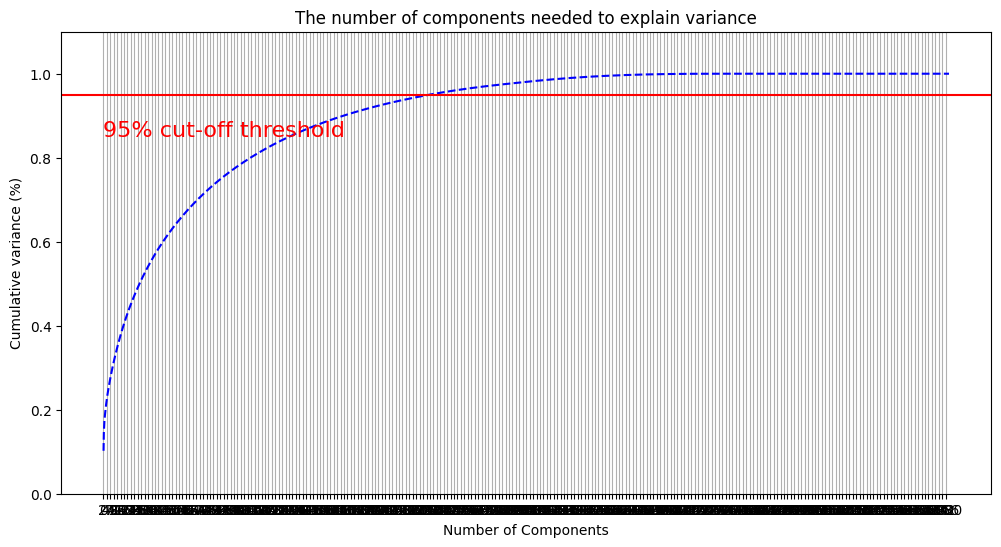

In [23]:
pca = PCA().fit(scaled_data)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 5905, step=1)
y_axe = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_axe, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5904, step=24))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)
X_pca.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
gnb_model = GaussianNB()
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier()

In [121]:
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)

In [122]:
print(f'ROC-AUC LogisticRegression: {roc_auc_score(y_test, lr_pred)}')
print(f'ROC-AUC kNN: {roc_auc_score(y_test, knn_pred)}')
print(f'ROC-AUC GaussianNB: {roc_auc_score(y_test, gnb_pred)}')

ROC-AUC LogisticRegression: 0.714079647362821
ROC-AUC kNN: 0.5769889040887672
ROC-AUC GaussianNB: 0.6125885392916857


In [123]:
svc = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lightgbm = LGBMClassifier()
catboost = CatBoostClassifier(silent=True)

In [124]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

xgboost.fit(X_train, y_train)
xgboost_pred = xgboost.predict(X_test)

lightgbm.fit(X_train, y_train)
lightgbm_pred = lightgbm.predict(X_test)

catboost.fit(X_train, y_train)
catboost_pred = catboost.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:38:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2920, number of negative: 1803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 580125
[LightGBM] [Info] Number of data points in the train set: 4723, number of used features: 2275
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618251 -> initscore=0.482132
[LightGBM] [Info] Start training from score 0.482132


In [125]:
print(f'ROC-AUC SupportVectorClassifier: {roc_auc_score(y_test, svc_pred)}')
print(f'ROC-AUC DecisionTreeClassifier: {roc_auc_score(y_test, dtc_pred)}')
print(f'ROC-AUC RandomForestClassifier: {roc_auc_score(y_test, rfc_pred)}')
print(f'ROC-AUC XGBoost: {roc_auc_score(y_test, xgboost_pred)}')
print(f'ROC-AUC LightGBM: {roc_auc_score(y_test, lightgbm_pred)}')
print(f'ROC-AUC CatBoost: {roc_auc_score(y_test, catboost_pred)}')

ROC-AUC SupportVectorClassifier: 0.6930551755585955
ROC-AUC DecisionTreeClassifier: 0.5858413132694938
ROC-AUC RandomForestClassifier: 0.6345812433500533
ROC-AUC XGBoost: 0.6465465876272989
ROC-AUC LightGBM: 0.6868931448548412
ROC-AUC CatBoost: 0.6677534579723362


In [126]:
# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [127]:
# import optuna

# def objective(trial):
#     params = {
#         "iterations": 500,
#         "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15, log=True),
#         "depth": trial.suggest_int("depth", 1, 5),
#         # "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 7),
#         # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#     }

#     model = CatBoostClassifier(**params, silent=True, random_seed=42)
#     model.fit(X_train_pca, y_train_pca)
#     predictions = model.predict(X_test_pca)
#     roc_auc_metric = roc_auc_score(y_test_pca, predictions)
#     return roc_auc_metric

In [128]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=5)

In [129]:
# print('Best hyperparameters:', study.best_params)
# print('Best roc_auc:', study.best_value)

In [130]:
# params = {
#     'iterations': [500],
#     'learning_rate': [0.01, 0.1],
#     'depth': [2, 4],
#     # 'l2_leaf_reg': [2, 3],
#     # 'loss_function': ['Logloss', 'CrossEntropy'],
#     # 'loss_function': ['Logloss'],
#     # 'logging_level': ['Silent'],
#     # 'random_seed': [42]
# }

In [131]:
# model = CatBoostClassifier()

In [132]:
# %%time
# grid_search = GridSearchCV(model, params, scoring='roc_auc', cv=3)

# grid_search.fit(X_train_pca, y_train_pca)


# print(grid_search.best_params_)


# auc_score = grid_search.score(X_test_pca, y_test_pca)
# print(f'AUC: {auc_score}')

###ML part for tf-IDF

In [133]:
X = df_final_tfidf.drop(['feeling_auto', 'lemmatized'], axis=1)
y = df_final_tfidf['feeling_auto']

In [134]:
X.shape

(5904, 6121)

In [135]:
scaler = MinMaxScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)

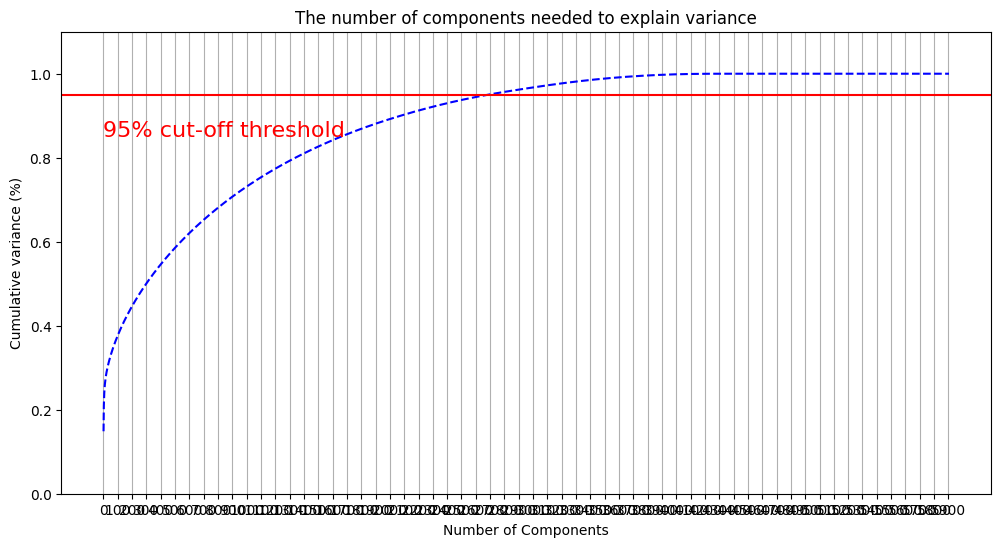

In [136]:
pca = PCA().fit(scaled_data)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 5905, step=1)
y_axe = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y_axe, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5904, step=100))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [137]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)
X_pca.shape

(5904, 2685)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [139]:
gnb_model = GaussianNB()
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier()

In [140]:
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)

In [141]:
print(f'ROC-AUC LogisticRegression: {roc_auc_score(y_test, lr_pred)}')
print(f'ROC-AUC kNN: {roc_auc_score(y_test, knn_pred)}')
print(f'ROC-AUC GaussianNB: {roc_auc_score(y_test, gnb_pred)}')

ROC-AUC LogisticRegression: 0.6963018695850433
ROC-AUC kNN: 0.5422906216750265
ROC-AUC GaussianNB: 0.6013877488980088


In [142]:
svc = SVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lightgbm = LGBMClassifier()
catboost = CatBoostClassifier(silent=True)

In [143]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

xgboost.fit(X_train, y_train)
xgboost_pred = xgboost.predict(X_test)

lightgbm.fit(X_train, y_train)
lightgbm_pred = lightgbm.predict(X_test)

catboost.fit(X_train, y_train)
catboost_pred = catboost.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:01:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2920, number of negative: 1803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684675
[LightGBM] [Info] Number of data points in the train set: 4723, number of used features: 2685
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618251 -> initscore=0.482132
[LightGBM] [Info] Start training from score 0.482132


In [144]:
print(f'ROC-AUC SupportVectorClassifier: {roc_auc_score(y_test, svc_pred)}')
print(f'ROC-AUC DecisionTreeClassifier: {roc_auc_score(y_test, dtc_pred)}')
print(f'ROC-AUC RandomForestClassifier: {roc_auc_score(y_test, rfc_pred)}')
print(f'ROC-AUC XGBoost: {roc_auc_score(y_test, xgboost_pred)}')
print(f'ROC-AUC LightGBM: {roc_auc_score(y_test, lightgbm_pred)}')
print(f'ROC-AUC CatBoost: {roc_auc_score(y_test, catboost_pred)}')

ROC-AUC SupportVectorClassifier: 0.6930551755585955
ROC-AUC DecisionTreeClassifier: 0.6099452804377565
ROC-AUC RandomForestClassifier: 0.6256923544611643
ROC-AUC XGBoost: 0.6534731722146223
ROC-AUC LightGBM: 0.6618483052135582
ROC-AUC CatBoost: 0.6774099407204742
